#Analyzing HTAN scATACseq Data Using SnapATAC2

```
Title: Analyzing HTAN scATACseq Data
Author: Dar'ya Pozhidayeva (dpozhida@systemsbiology.org)
Created: October 28th, 2024
```

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/isb-cgc/Community-Notebooks/blob/master/HTAN/Python%20Notebooks/Analyzing_HTAN_scATACseq_Data_Using_SnapATAC2.ipynb)

# 1. Introduction & Overview
[HTAN](https://humantumoratlas.org/) is a National Cancer Institute (NCI)-funded Cancer Moonshot initiative to construct 3-dimensional atlases of the dynamic cellular, morphological, and molecular features of human cancers as they evolve from precancerous lesions to advanced disease ( [Cell April 2020](https://www.sciencedirect.com/science/article/pii/S0092867420303469) )


### 1.1 Goal

The goal of this notebook is to show users how public HTAN single cell ATACseq level 4 data can be analyzed using the SnapATAC2 python package: https://github.com/kaizhang/SnapATAC2. Specifically, we'll be showcasing the construction and analysis of a fragment file from data in BigQuery. For the analsis, we'll perform some clustering and plotting of the data. The total time for this notebook should be about 20 minutes.


### 1.2 Inputs, Outputs, & Data

The data used in this analysis comes from HTAN single cell ATAC sequencing data (Level 4). The dataset is pulled from Google BigQuery, which was derived in August 2024 from an RDS file (Synapse ID: syn51301050) submitted by the CHOP HTAN Center.



In terms of methods, the authors reported that sorted cells were subjected to nuclei isolation protocol. Nuclei were processed using 10x Genomics Chromium controller and the Single Cell ATAC Reagent Kits V1 protocol. Libraries were sequenced on a Nova-Seq 6000 with 49:8:16:49 paired-end format.

The published work associated with this dataset along with more information can be found here: https://ashpublications.org/blood/article/139/14/2198/482898/Single-cell-multiomics-reveals-increased

# 2. Relevant Libraries for Analysis

To get started, we'll need to download and call a few python libraries!

In [ ]:
import pandas as pd
import seaborn as sns
import gzip

# 3. Google Authentication

Running the BigQuery cells in this notebook requires a Google Cloud Project, instructions for creating a project can be found in the [Google Documentation](https://cloud.google.com/resource-manager/docs/creating-managing-projects#console). The instance needs to be authorized to bill the project for queries. For more information on getting started in the cloud see [Quick Start Guide to ISB-CGC](https://nbviewer.org/github/isb-cgc/Community-Notebooks/blob/master/Notebooks/Quick_Start_Guide_to_ISB_CGC.ipynb) and alternative authentication methods can be found in the [Google Documentation](https://cloud.google.com/resource-manager/docs/creating-managing-projects#console).

## 3.1 Authenticating with Google Credentials

#### Option 1. Running in Google Colab

Before getting started, keep in mind that there are some differences in running this notebook depending on if you are using Google Colab or running locally. We've included notes such as the following to skip or run specific lines of code depending on your setup.

If you are using Google Colab, run the code block below to authenticate:

In [ ]:
from google.colab import auth
auth.authenticate_user()

#### Option 2. Running on local machine

Alternatively, if you're running the notebook locally, take the following steps to authenticate.

1.   Run `gcloud auth application-default login` on your local machine
2.   Run the command below replacing `<path to key>` with the path to your credentials file

In [ ]:
#%env GOOGLE_APPLICATION_CREDENTIALS=<path to key>

## 3.2 Initializing the Google BigQuery client

In [ ]:
# Import the Google BigQuery client
from google.cloud import bigquery

# Set the google project that will be billed for this notebook's computations
google_project = 'my-project'

# Create a client to access the data within BigQuery
client = bigquery.Client(google_project)

This notebook will also be saving and accesssing data to/from google drive. In order to do this, the drive is first mounted as follows.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#4. Pull Data from Google BigQuery

Once authentication and project setup is complete, we can work with HTAN data available in BigQuery. For the following query, we'll test to see if we can access the correct ATACseq table.

In [ ]:
scatac_table = client.query("""
SELECT * FROM `htan-dcc.ISB_CGC_r6.seurat_scATAC_patient_clean` LIMIT 1
    """).result().to_dataframe()

In [ ]:
scatac_table

,iVar,iObs,X_value,chromosomal_position,tss_region_flag,sample,Ctype,projCtype,pseudotime,nCount_ATAC,nFeature_ATAC
0,PAYWJZ_CAGCTAACAGGGTAAC,AGRN,1.0,chr1-1019129-1021106,Tss,PAYWJZ,T/NK,T-like,16.65553,21064.0,12513


Above, we see that the anticipated dataset is printed as expected.
In terms of table columns, we see that iVar reflects gene IDs, iObs shows indices to cell barcodes, X_value reflects peak counts and chromosomal_position shows the chromosomal region in bp. More information for columns is availble in the table description and schema in BigQuery.

# 5.Create a Fragment File for ATAC Seq Analysis

Now that everything is set up, we'll move on to creating a fragment file from the available data. Many ATAC seq pipelines utilize fragment files as a starting point for the analysis. Generally, the cellranger count pipeline outputs a BED-like tabular file, where each line represents a unique ATAC-seq fragment captured by the assay. Each fragment is created by two separate transposition events, which create the two ends of the observed fragment. Each unique fragment may generate multiple duplicate reads. These duplicate reads are collapsed into a single fragment record.

For more information on the fragment file format, you can visit: https://support.10xgenomics.com/single-cell-atac/software/pipelines/latest/output/fragments

This is the standard we'll be following in this tutorial.

Additionally, this dataset is large and we won't make a single fragment file from the entire set here. Instead, we'll subset to relevant genes and samples that were reported in the publication associated with the set.

In the paper, the authors list the blast population as being defined by clusters of cells expressing CD19, HOXA9, MEIS1, and MEF2C (CD19+ blasts; supplemental Table 2). Here, we'll use these genes within one patient as a basis for subsetting our whole data set.

In [ ]:
# We'll use the following query to fetch the gene symbols for the array
data_subset = client.query("""
SELECT * FROM `htan-dcc.ISB_CGC_r6.seurat_scATAC_patient_clean`
WHERE (sample = 'PAYUZJ') AND (iObs = 'CD19' OR iObs = 'HOXA9' OR iObs = 'MEIS1' OR iObs = 'MEF2C')
""").result().to_dataframe()

In [ ]:
data_subset

,iVar,iObs,X_value,chromosomal_position,tss_region_flag,sample,Ctype,projCtype,pseudotime,nCount_ATAC,nFeature_ATAC
0,PAYUZJ_CGAGTTAAGAAAGGGT,CD19,1.0,chr16-28936125-28936955,None,PAYUZJ,T/NK,T-like,133.57374,14833.0,9713
1,PAYUZJ_CTCTCAGTCTATCCTA,CD19,4.0,chr16-28930494-28932834,Tss,PAYUZJ,Blasts,Pre-pro-B-like,71.26066,24600.0,16327
2,PAYUZJ_ATTGTGGGTTCAGAAA,CD19,2.0,chr16-28936125-28936955,None,PAYUZJ,Progenitors,HSPC-like,5.60321,23232.0,15904
3,PAYUZJ_CTCAGAACAGCAACAG,CD19,3.0,chr16-28936125-28936955,None,PAYUZJ,Progenitors,HSPC-like,5.60321,15453.0,11244
4,PAYUZJ_AACCAACCATCCTCGT,CD19,2.0,chr16-28930494-28932834,Tss,PAYUZJ,Blasts,Pre-pro-B-like,70.83022,21935.0,14305
...,...,...,...,...,...,...,...,...,...,...,...
47473,PAYUZJ_TATCTGTAGTAATGTG,MEIS1,1.0,chr2-66432698-66435586,Tss,PAYUZJ,Blasts,DC-Progenitor-like,28.28660,8002.0,6134
47474,PAYUZJ_TATCTGTAGTAATGTG,MEIS1,1.0,chr2-66437571-66438467,Tss,PAYUZJ,Blasts,DC-Progenitor-like,28.28660,8002.0,6134
47475,PAYUZJ_TATCTGTAGTAATGTG,MEIS1,1.0,chr2-66495800-66496543,None,PAYUZJ,Blasts,DC-Progenitor-like,28.28660,8002.0,6134
47476,PAYUZJ_TGGCAATCACGAACGA,MEIS1,1.0,chr2-66443704-66444872,None,PAYUZJ,Blasts,DC-Progenitor-like,28.28660,4667.0,3657


Next, we create the fragment file by adhering to the standards provided in the documentation above:

In [ ]:
cell_barcode = data_subset['iVar'].str.rsplit('_', n=1).str.get(1)
chrom_positions = data_subset['chromosomal_position'].str.split('-', expand=True)
expression = data_subset['X_value']

fragment_file = pd.concat([chrom_positions, cell_barcode], axis=1)
fragment_file = pd.concat([fragment_file, expression], axis=1)
fragment_file['X_value'] = fragment_file['X_value'].astype(int)

In [ ]:
fragment_file

,0,1,2,iVar,X_value
0,chr16,28936125,28936955,TCGTTCGCAGCAAACG,1
1,chr16,28930494,28932834,CTGTATTCATGCCTTC,1
2,chr16,28930494,28932834,TAGCACATCCGTTAGA,1
3,chr16,28936125,28936955,TCAATTCGTGACCAGA,1
4,chr16,28930494,28932834,ACTTTCAAGAAGGGCG,1
...,...,...,...,...,...
47473,chr5,88895416,88897643,TATCTGTAGTAATGTG,1
47474,chr5,88842692,88843276,TGGCAATCACGAACGA,1
47475,chr5,88849859,88851562,TGGCAATCACGAACGA,1
47476,chr5,88875261,88876108,TGGCAATCACGAACGA,1


In [ ]:
#Check the frequency table of count values
fragment_file.X_value.value_counts()

,count
X_value,
1,34721
2,8627
3,2566
4,947
5,376
6,143
7,57
8,28
9,8


Now we export the table above into a compressed-tsv format which is standard for frament files and save it to our mounted Google Drive.

In [ ]:
fragment_file.to_csv('/content/drive/MyDrive/fragment_file.tsv.gz', sep ='\t', compression='gzip', header = False, index = False)

#6. Analyse the Data using SnapATAC2

In [ ]:
!pip install snapatac2
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.2/687.2 kB 10.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached hmmlearn-0.3.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.0 kB)
  Using cached cykhash-2.0.1-cp310-cp310-linux_x86_64.whl
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.8 MB/s

In [ ]:
import snapatac2 as snap
import umap.umap_ as umap

Once installed and loaded, we'll use the import_data module to read in our previously created fragment file. This will read our fragment file into the session in an AnnData format. Given that this data has been previously processed, we'll lower the number of minimum fragments (set to 200 by default). For chromosome sizes, we'll use Human Genome 38 as provided by the package.

More documentation for snapatac2 modules can be found here: https://kzhang.org/SnapATAC2/tutorials/index.html

For more information on the AnnData format, see our other notebooks on creating AnnData structures or check out the documentation here: https://anndata.readthedocs.io/en/latest/


In [ ]:
fragment_data = snap.pp.import_data(
    '/content/drive/MyDrive/fragment_file.tsv.gz',
    chrom_sizes=snap.genome.hg38,
    sorted_by_barcode=False,
    min_num_fragments=0,
    )

In [ ]:
fragment_data

AnnData object with n_obs × n_vars = 5907 × 0
    obs: 'n_fragment', 'frac_dup', 'frac_mito'
    uns: 'reference_sequences'
    obsm: 'fragment_paired'

In [ ]:
fragment_data.var

""


In the output above, we see that our data has been read in and some basic QC metrics have been performed by default (n_fragment, frac_dup, etc).

Using this AnnData object we'll employ the frag_size_distr() module to calculate and plot the size distribution of fragments in this dataset.

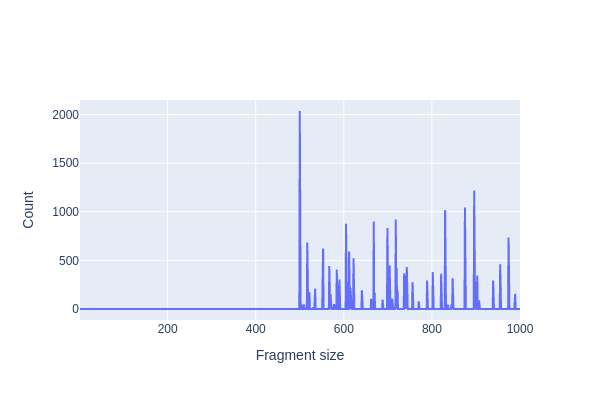

In [ ]:
snap.pl.frag_size_distr(fragment_data, interactive=False)

The plotting functions in SnapATAC2 can optionally return a plotly Figure object that can be further customized using plotly’s API. In the example below, we change the y-axis to log-scale.

In [ ]:
fig = snap.pl.frag_size_distr(fragment_data, show=False)
fig.update_yaxes(type="log")
fig.show()

In both figures above, we see that the data has been pre-filtered by the authors.

We next create a cell by bin matrix containing insertion counts across genome-wide 500-bp bins using the add_tile_matrix() module.

In [ ]:
snap.pp.add_tile_matrix(fragment_data)

Next, we perform feature selection using pp.select_features(). The result is stored in data.var['selected'] and will be automatically utilized by relevant functions such as pp.scrublet() and tl.spectral().

The default feature selection algorithm chooses the most accessible features. The n_features parameter determines the number of features or bins used in subsequent analysis steps. Generally, including more features improves resolution and reveals finer details, but it may also introduce noise. To optimize results, experiment with the n_features parameter to find the most appropriate value for your specific dataset.

In [ ]:
snap.pp.select_features(fragment_data, n_features=200)

#7. Clustering

Lastly, we'll illustrate how the this data can be clustered.

To calculate the lower-dimensional representation of single-cell chromatin profiles, the SnapATAC2 library employs spectral embedding for dimensionality reduction. The resulting data is stored in data.obsm['X_spectral']. Comprehensive information about the dimension reduction algorithm we utilize can be found in their [algorithm documentation](https://kzhang.org/epigenomics-analysis/dim_reduct.html).

In [ ]:
snap.tl.spectral(fragment_data,)

In [ ]:
fragment_data

AnnData object with n_obs × n_vars = 5907 × 6062095
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'leiden', 'Ctype'
    var: 'count', 'selected'
    uns: 'reference_sequences', 'frag_size_distr', 'spectral_eigenvalue'
    obsm: 'fragment_paired', 'X_spectral', 'X_umap'
    obsp: 'distances'

We then use UMAP to embed the cells to 2-dimension space for visualization purpose. This step will have to be run after snap.tl.spectral as it uses the lower dimesnional representation created by the spectral embedding.

In [ ]:
snap.tl.umap(fragment_data)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



We next perform graph-based clustering to identify cell clusters. We first build a k-nearest neighbour graph using snap.pp.knn, and then use the Leiden community detection algorithm to identify densely-connected subgraphs/clusters in the graph.

In [ ]:
snap.pp.knn(fragment_data, n_neighbors=12)
snap.tl.leiden(fragment_data)

Lastly, we're able to plot our clustering results.

In [ ]:
snap.pl.umap(fragment_data, color='leiden', interactive=True, height=500, width=800)

In order to confirm that the clusters above contain the cell types we anticipate, we'll add the existing cell labels from the dataset pulled in from BQ to our AnnData object. To do this we'll perform the following merge:

In [ ]:
cell_type = data_subset[['iVar', 'Ctype']]
cell_type['iVar'] = cell_type['iVar'].str.rsplit('_', n=1).str.get(1)
cell_type.drop_duplicates(inplace=True)
cell_type.set_index('iVar', inplace=True)

<ipython-input-31-30a87d3bb5f5>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-31-30a87d3bb5f5>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
fragment_data.obs = fragment_data.obs.merge(how='left',right=cell_type, left_index=True, right_index=True)

Now when we plot the UMAP again, we can see that although there is some mixture of cells shown within the dataset, the predominate group shown are blasts as the paper cited.

In [ ]:
snap.pl.umap(fragment_data, color='Ctype', interactive=True, height=800, width=800)

#8. Relevant Citations and Links

[Chen C, et al., Single-cell multiomics reveals increased plasticity, resistant populations, and stem-cell–like blasts in KMT2A-rearranged leukemia](https://ashpublications.org/blood/article/139/14/2198/482898/Single-cell-multiomics-reveals-increased)

[HTAN Portal](https://humantumoratlas.org/)   

[Overview paper, Cell, April 2020](https://www.sciencedirect.com/science/article/pii/S0092867420303469)